# Method for Generating Randomly Perturbed Density Operators Subject to Different Sets of Constraints


This paper presents a general method for producing randomly perturbed density operators subject to different sets of constraints. The perturbed density operators are a specified “distance” away from the state described by the original density operator. This approach is applied to a bipartite system of qubits and used to examine the sensitivity of various entanglement measures on the perturbation magnitude. The constraint sets used include constant energy, constant entropy, and both constant energy and entropy. The method is then applied to produce perturbed random quantum states that correspond with those obtained experimentally for Bell states on the IBM quantum device ibmq manila. The results show that the methodology can be used to simulate the outcome of real quantum devices where noise, which is important both in theory and simulation, is present.

https://arxiv.org/abs/2112.12247

In [69]:
import numpy as np
from scipy.constants import hbar
from scipy import linalg
from RPM import gammae_fun, apply_constraints
from tqdm import tqdm
from Properties import unit_trace, energy, entropy
from Properties import concurrence, fidelity, mutualInf, distanceBS, CHSH
import matplotlib.pyplot as plt

si = np.eye(2, dtype = complex)
sx = np.array([[0,1],[1,0]], dtype = complex)
sy = np.array([[0,-1j],[1j,0]], dtype = complex)
sz = np.array([[1,0],[0,-1]], dtype = complex)
sn = [si, sx, sy, sz]

import warnings
warnings.filterwarnings('ignore')

## Set of conditions from the experiments on ibmq_manila

array([[ 0.49730336+0.j        , -0.00438501+0.00391002j,
         0.01125905+0.00243797j,  0.41532291-0.00892185j],
       [-0.00438501-0.00391002j,  0.04896141+0.j        ,
         0.00715565-0.00639054j, -0.0161785 -0.02197566j],
       [ 0.01125905-0.00243797j,  0.00715565+0.00639054j,
         0.04640148+0.j        ,  0.00633342-0.03982783j],
       [ 0.41532291+0.00892185j, -0.0161785 +0.02197566j,
         0.00633342+0.03982783j,  0.40733376+0.j        ]])

In [49]:
omega1 = 5.037e9; omega2 = 4.951e9 # Hamiltonian constants
experiment = np.load("./Data/etas_exp.npy", allow_pickle=True).item() # Loading the density operators from experiments
N = 200 # Ranfom cases
H = -0.5 * hbar * (2 * np.pi)*(omega1 * np.kron(sz,si) + omega2 * np.kron(si, sz)) / (hbar * omega1) # Hamiltonian of the two-qubit system
I = np.eye(4) # Identity constraint
sigma = 0.05 # Perturbation of the lambda values standard deviation from a normal distribution
np.random.seed(1) # Fixing random number generated
etas = np.random.normal(loc = 0.0, scale = sigma, size = (N,len(sn),len(sn))) # Generating 200 random states
po = np.array([[0.5,0,0,0.5],
               [0,0,0,0],
               [0,0,0,0],
               [0.5,0,0,0.5]]) # Ideal density state operator
gamma0 = linalg.sqrtm(po)
gammaes = gammae_fun(gamma0, etas)#, epsilon)
results = {"C1":{},"C1&C2":{},"C1&C3":{},"C1&C2&C3":{}, "Exp":{},"eta":etas,
           "H":H, "po":po, "gammaes":gammaes}
prs = experiment["Exp"]

# Experimental energy and entropy 
E_exps = np.array([(pi @ H).trace().real for pi in prs])
S_exps = np.array([(-pi @ linalg.logm(pi)).trace().real for pi in prs])
S_mean = S_exps.mean(); S_std = S_exps.std()
E_mean = E_exps.mean(); E_std = E_exps.std()


Text(0.5, 0.98, 'Energy and entropy Histogram from 200 experiments on ibmq_manila')

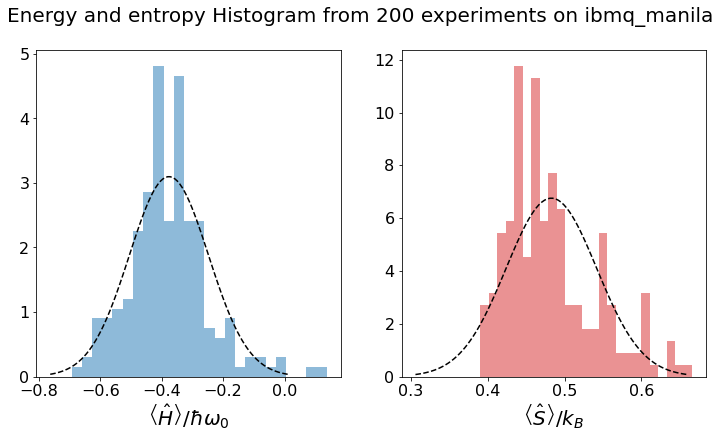

In [50]:
exps = [E_exps, S_exps]
colors = ["tab:blue", "tab:red"]
names = [r"$\left< \hat H \right>/\hbar \omega_0$", r"$\left< \hat S \right>/k_B$"]

fig, ax = plt.subplots(1, 2, figsize = (12,6))
for i in range(1):
    for j in range(2):
        ax[j].hist(exps[j], 25, density=True, color=colors[j], alpha=0.5)
        mu = exps[j].mean(axis=0)
        std = exps[j].std(axis=0)
        t = np.linspace(mu-3*std, mu+3*std, 100)
        ax[j].plot(t, (1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*((t - mu)/std)**2),"--", color="black")
        ax[j].set_xlabel(names[j], fontsize=20)
        ax[j].tick_params("x",labelsize=16)
        ax[j].tick_params("y",labelsize=16)
fig.suptitle("Energy and entropy Histogram from 200 experiments on ibmq_manila", fontsize=20)

# Case 1: Unit trace constraint C1


In [51]:
init = [0.01]
gammars = []; lambdasT = [] 
C = [unit_trace]
G = [I]
for gammae in tqdm(gammaes):
    C_exp = [1]
    lambdas, gammar = apply_constraints(gammae, po, C, C_exp, G, init)
    gammars.append(gammar)
    lambdasT.append(lambdas)
results["C1"]["gammars"] = np.array(gammars)    
results["C1"]["lambdas"] = np.array(lambdas)    

  0%|          | 0/200 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 200/200 [00:00<00:00, 745.85it/s]


## Case 2: Unit trace and energy constraints C1 & C2

In [52]:
init = [1e-2, 1e-2]
gammars = []; lambdas = []
C = [unit_trace, lambda p: energy(p, H)]
G = [I, H]
for gammae in tqdm(gammaes):
    E_random = np.random.normal(loc=E_mean, scale=E_std) # Randomly select the energy from a normal distribution 
    C_exp = [1, E_random] 
    lambdas, gammar = apply_constraints(gammae, po, C, C_exp, G, init)
    gammars.append(gammar)
    lambdasT.append(lambdas)
results["C1&C2"]["gammars"] = np.array(gammars)
results["C1&C2"]["lambdas"] = np.array(lambdas)   

100%|██████████| 200/200 [00:00<00:00, 401.99it/s]


## Case 3: Unit trace and entropy C1 & C3 

In [53]:
init = [1e-2, 1e-2]
gammars = []; lambdas = []
C = [unit_trace, entropy]
for gammae in tqdm(gammaes):
    pe = gammae @ gammae.T.conjugate()
    G = [I, - I - linalg.logm(pe)]
    S_random = np.random.normal(loc=S_mean, scale=S_std) # Randomly select the entropy from a normal distribution 
    C_exp = [1, S_random] 
    lambdas, gammar = apply_constraints(gammae, po, C, C_exp, G, init)
    gammars.append(gammar)
    lambdasT.append(lambdas)
results["C1&C3"]["gammars"] = np.array(gammars)
results["C1&C3"]["lambdas"] = np.array(lambdas)   

100%|██████████| 200/200 [00:22<00:00,  8.86it/s]


## Case 4: Unit trace, energy, and entropy C1 & C2 & C3

In [54]:
init = [1e-2, 1e-2, 1e-2]
gammars = []; lambdas = []
C = [unit_trace, lambda p: energy(p, H), entropy]
for gammae in tqdm(gammaes):
    pe = gammae @ gammae.T.conjugate()
    G = [I, H, - I - linalg.logm(pe)]
    E_random = np.random.normal(loc=E_mean, scale=E_std) # Randomly select the energy from a normal distribution 
    S_random = np.random.normal(loc=S_mean, scale=S_std) # Randomly select the energy from a normal distribution 
    C_exp = [1, E_random, S_random] 
    lambdas, gammar = apply_constraints(gammae, po, C, C_exp, G, init)
    gammars.append(gammar)
    lambdasT.append(lambdas)
results["C1&C2&C3"]["gammars"] = np.array(gammars)
results["C1&C2&C3"]["lambdas"] = np.array(lambdas)  

100%|██████████| 200/200 [00:24<00:00,  8.07it/s]


## Properties from the constrained perturbed states 

In [55]:
sections = ["C1", "C1&C2", "C1&C3", "C1&C2&C3", "Exp"]
fid = lambda p: fidelity(po, p)
funs = {"E":lambda p: energy(p, H), "S":entropy, "C":concurrence, "F":lambda p: fidelity(po, p), "MI":mutualInf, "DBS":distanceBS, "CHSH":CHSH}
for sec in sections:
    if sec == "Exp":
        gammars = np.array([linalg.sqrtm(pr) for pr in experiment["Exp"]])
    else:
        gammars = results[sec]["gammars"]
    variables = {"E":[], "S":[], "C":[], "F":[], "MI":[], "DBS":[], "CHSH":[]}
    for gammar in tqdm(gammars):
        pr = gammar @ gammar.T.conjugate()
        for key in variables.keys():
            if key == "DBS":
                variables[key].append(distanceBS(gamma0, gammar))
            else:
                variables[key].append(funs[key](pr))
    for var in variables:
        results[sec][var] = variables[var]

100%|██████████| 200/200 [00:01<00:00, 187.29it/s]


In [65]:
results["e0"] = energy(po, H)
results["s0"] = entropy(po)
results["F0"] = 1
results["MI0"] = mutualInf(po)
results["DBS0"] = distanceBS(gamma0, gamma0)
results["CHSH0"] = CHSH(po)
results["C0"] = concurrence(po)
results["etas_exp"] = experiment["etas"]
results["etas_sim"] = etas
results["E_exps"] = E_exps
results["S_exps"] = S_exps

/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
/Users/alejomonbar/Documents/GitHub/Generating-randomly-perturbed-density-operators/Properties.py:98: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(theta)


In [62]:
data = results
data_Exp = results["Exp"]
labels = ["C1", "C1 & C2", "C1 & C3", "C1 & C2 & C3"]
marker = ["o", "^", "h","d", "s"]
args = {'markersize':8,'markeredgecolor':'black','markeredgewidth':0.2}
Exp = "Exp_Norm"
font = 18
sections = ["C1", "C1&C2", "C1&C3", "C1&C2&C3"]


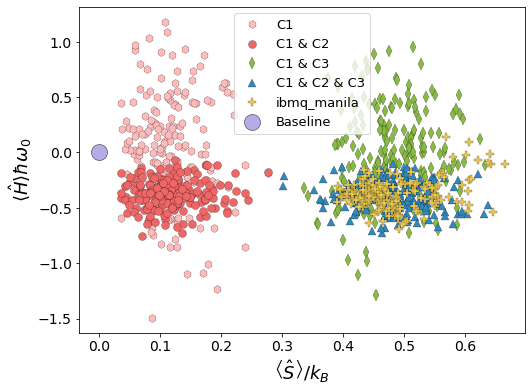

In [70]:
fig1, ax1 = plt.subplots(figsize=(8,6))
marker = ["h", "o","d", "^", "h", "s"]
for n, sec in enumerate(sections):
    ax1.plot(data[sec]["S"], np.array(data[sec]["E"]), marker[n], label = labels[n],color = color_[n], **args)
ax1.plot(data_Exp["S"], data_Exp["E"], "P", label = "ibmq_manila", color=color_[n+1], **args)
ax1.plot([data["s0"]], [data["e0"]],"o", label= "Baseline", markersize=16, color = color_[n+2],markeredgewidth=0.6, alpha=0.7, markeredgecolor='black')
ax1.tick_params("x",labelsize=14)
ax1.tick_params("y",labelsize=14)
ax1.set_xlabel(r"$\left< \hat S \right>/k_B$", fontsize=font)
ax1.set_ylabel(r"$\langle \hat H \rangle\hbar \omega_0$", fontsize=font)
ax1.legend(fontsize=13)

In [72]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, n=0, alphas=[1]):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.plot(x, y, marker[n], label=labels[n], alpha=alphas[n], **args)
    ax_histx.hist(x, bins=15, alpha=alphas[n])
    ax_histy.hist(y, bins=15, orientation='horizontal', alpha=alphas[n])
    ax_histx.tick_params("x",labelsize=14)
    ax_histx.tick_params("y",labelsize=14)
    ax_histy.tick_params("x",labelsize=14)
    ax_histy.tick_params("y",labelsize=14)
    
marker = ["o", "^", "*", "P"]
sections =["C1&C2", "C1&C3", "C1&C2&C3"]
labels = ["C1 & C2", "C1 & C3", "C1 & C2 & C3", "ibmq_manila"]
Exp = "Hist"
# definitions for the axes
left, width = 0.2, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
alphas = [1, 0.6, 0.8, 0.8]

## Energy-entropy diagram 

The figure shows the energy-entropy diagram of the simulation of the ibmq manila device based on the ηi,j values using the normal distributions N(Eμ,Eσ) and N(Sμ,Sσ) for the energy and entropy, respectively. The yellow crosses are the 200 experi- mental values.

Text(-0.15, 2, '(a)')

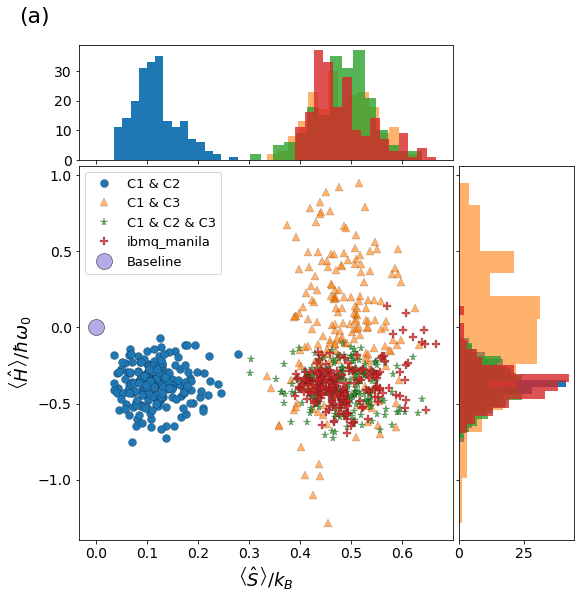

In [73]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
for n, sec in enumerate(sections):
    scatter_hist(data[sec]["S"], np.array(data[sec]["E"]), ax, ax_histx, ax_histy, n, alphas)
scatter_hist(data_Exp["S"], data_Exp["E"], ax, ax_histx, ax_histy, n+1, alphas)
ax.plot([data["s0"]], [data["e0"]],"o", label= "Baseline", markersize=16, color = color_[-1],markeredgewidth=0.6, alpha=0.7, markeredgecolor='black')

ax.legend(fontsize=13)
ax.tick_params("x",labelsize=14)
ax.tick_params("y",labelsize=14)
ax.set_xlabel(r"$\left< \hat S \right>/k_B$", fontsize=font)
ax.set_ylabel(r"$\left< \hat H \right>/\hbar \omega_0$", fontsize=font)
ax.text(-0.15, 2,"(a)", fontsize=22)

# Fidelity - Distance measured
The figure shows the fidelity versus the distance measure.

Text(-0.11, 1.1, '(b)')

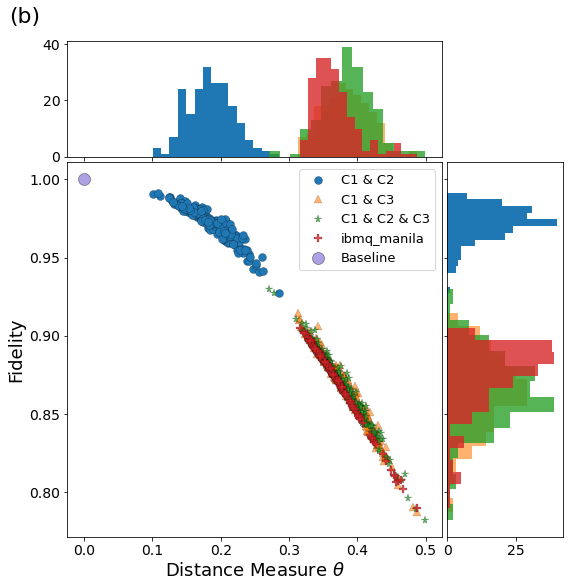

In [74]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
for n, sec in enumerate(sections):
    scatter_hist(np.array(data[sec]["DBS"]), np.array(data[sec]["F"]), ax, ax_histx, ax_histy, n, alphas)
scatter_hist(data_Exp["DBS"], data_Exp["F"], ax, ax_histx, ax_histy, n+1, alphas)
ax.plot([0], [1],"o", label= "Baseline", markersize = 12,markeredgecolor='black',markeredgewidth=0.4, alpha=0.8, color=color_[5])
ax.legend(fontsize=13)
ax.tick_params("x",labelsize=14)
ax.tick_params("y",labelsize=14)
ax.set_xlabel(r"Distance Measure $\theta$", fontsize =font)
ax.set_ylabel("Fidelity", fontsize =font)
# ax.set_xlim(-0.05,2)
ax.text(-0.11,1.1,"(b)", fontsize=22)

## Entropy - Mutual Information

Text(-0.15, 1.7, '(a)')

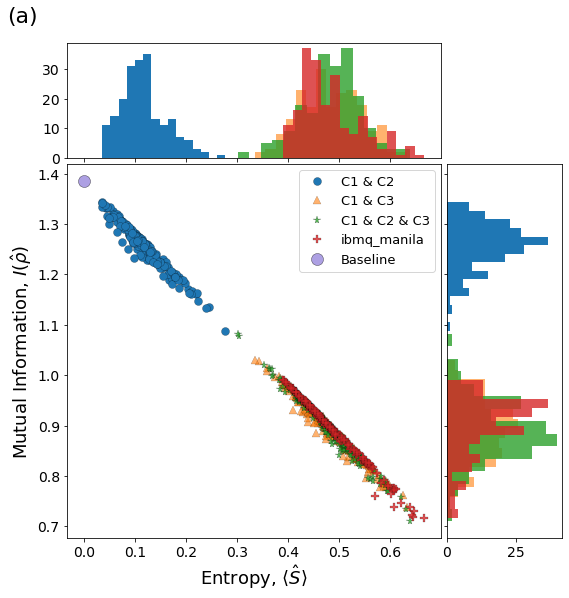

In [75]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
for n, sec in enumerate(sections):
    scatter_hist(data[sec]["S"], np.array(data[sec]["MI"]), ax, ax_histx, ax_histy, n, alphas)
scatter_hist(data_Exp["S"], data_Exp["MI"], ax, ax_histx, ax_histy, n+1, alphas)
ax.plot([data["s0"]], [data["MI0"]],"o", label= "Baseline", markersize = 12,markeredgecolor='black',markeredgewidth=0.4, alpha=0.8, color=color_[5])
ax.legend(fontsize=13)
ax.tick_params("x",labelsize=14)
ax.tick_params("y",labelsize=14)
ax.set_xlabel(r"Entropy, $\langle \hat S \rangle$", fontsize =font)
ax.set_ylabel(r"Mutual Information, $I(\hat\rho)$", fontsize =font)
ax.text(-0.15,1.7,"(a)", fontsize=22)

## Mutual information vs Concurrence

Text(0.6, 1.2, '(b)')

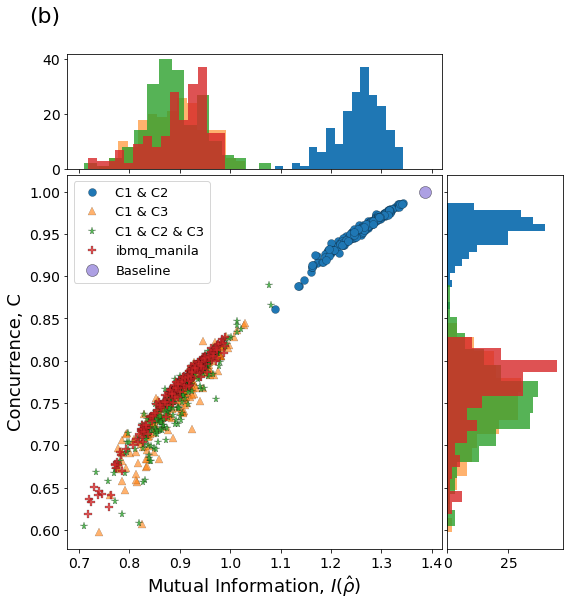

In [76]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
for n, sec in enumerate(sections):
    scatter_hist(data[sec]["MI"], np.array(data[sec]["C"]), ax, ax_histx, ax_histy, n, alphas)
scatter_hist(data_Exp["MI"], data_Exp["C"], ax, ax_histx, ax_histy, n+1, alphas)
ax.plot([data["MI0"]], [data["C0"]],"o", label= "Baseline", markersize = 12,markeredgecolor='black',markeredgewidth=0.4, alpha=0.8, color=color_[5])
ax.legend(fontsize=13)
ax.tick_params("x",labelsize=14)
ax.tick_params("y",labelsize=14)
ax.set_ylabel(r"Concurrence, C", fontsize =font)
ax.set_xlabel(r"Mutual Information, $I(\hat\rho)$", fontsize =font)
ax.text(0.6,1.2,"(b)", fontsize=22)

## Mutual information - CHSH

Text(0.57, 3.25, '(a)')

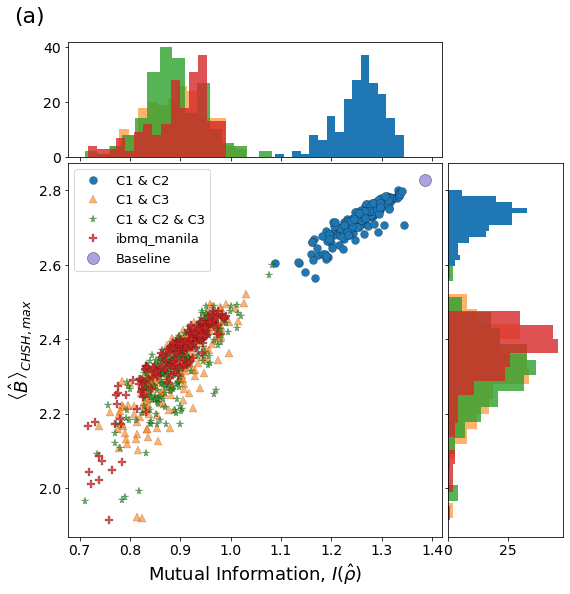

In [77]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
for n, sec in enumerate(sections):
    scatter_hist(data[sec]["MI"], np.array(data[sec]["CHSH"]), ax, ax_histx, ax_histy, n, alphas)
scatter_hist(data_Exp["MI"], data_Exp["CHSH"], ax, ax_histx, ax_histy, n+1, alphas)
ax.plot([data["MI0"]], [data["CHSH0"]],"o", label= "Baseline", markersize = 12,markeredgecolor='black',markeredgewidth=0.4, alpha=0.8, color=color_[5])
ax.legend(fontsize=13)
ax.tick_params("x",labelsize=14)
ax.tick_params("y",labelsize=14)
ax.set_ylabel(r"$\left< \hat B\right>_{CHSH,max}$", fontsize =font)
ax.set_xlabel(r"Mutual Information, $I(\hat\rho)$", fontsize =font)
ax.text(0.57,3.25,"(a)", fontsize=22)

## CHSH - Concurrence

Text(1.7, 1.19, '(b)')

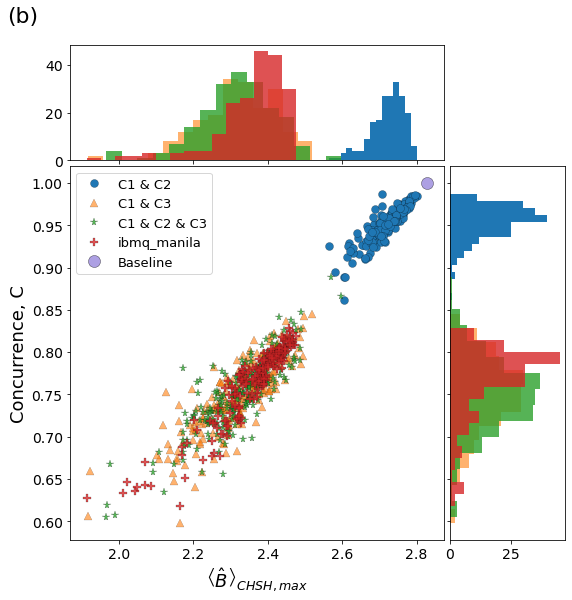

In [78]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
for n, sec in enumerate(sections):
    scatter_hist(data[sec]["CHSH"], np.array(data[sec]["C"]), ax, ax_histx, ax_histy, n, alphas)
scatter_hist(data_Exp["CHSH"], data_Exp["C"], ax, ax_histx, ax_histy, n+1, alphas)
ax.plot([data["CHSH0"]], [data["C0"]],"o", label= "Baseline", markersize = 12,markeredgecolor='black',markeredgewidth=0.4, alpha=0.8, color=color_[5])
ax.legend(fontsize=13)
ax.tick_params("x",labelsize=14)
ax.tick_params("y",labelsize=14)
ax.set_xlabel(r"$\left< \hat B\right>_{CHSH,max}$", fontsize =font)
ax.set_ylabel(r"Concurrence, C", fontsize =font)
ax.text(1.7,1.19,"(b)", fontsize=22)